In [452]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
import os
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Form Dataframe

In [453]:
lexical_df = pd.read_csv('/content/interview_transcripts_by_turkers.csv', header=None)
lexical_df.columns = ['InterviewID', 'Transcript']
lexical_df['InterviewID'] = lexical_df['InterviewID'].str.upper()
lexical_df.head()

,InterviewID,Transcript
0,P1,Interviewer: So how are you doing?|Interviewee...
1,P10,Interviewer: So how you doing?|Interviewee: G...
2,P11,Interviewer: So tell me about yourself. |Inte...
3,P12,Interviewer: So how are you doing today?|Inter...
4,P13,Interviewer: How are you doing today?|Intervie...


In [454]:
interviewee_responses = {}

# Iterate through the dataframe rows
for index, row in lexical_df.iterrows():
    transcript = row['Transcript']

    # Split the transcript into interview segments
    segments = transcript.split('|')

    # Extract interviewee responses
    interviewee_response = ""
    for segment in segments:
        if 'Interviewee:' in segment:
            interviewee_response += segment.replace('Interviewee:', '').strip() + " "

    # Append interviewee response to the list
    interviewee_responses[row['InterviewID']] = interviewee_response



In [455]:
interviewee_responses_df = pd.DataFrame.from_dict(interviewee_responses, orient='index')
interviewee_responses_df.columns = ['Transcript']
interviewee_responses_df.reset_index(level=0, inplace=True)
interviewee_responses_df.columns = ['InterviewID', 'Transcript']
interviewee_responses_df.head()

,InterviewID,Transcript
0,P1,Im pretty good. ok uhm so have you looked at...
1,P10,Great how about you? I'm a little [???] by th...
2,P11,Uhh I’m a junior at MIT uhh I’m double major...
3,P12,I'm good how are you? Ok so I'm a Junior at...
4,P13,Good. Ok umm I'm currently a junior at M.I.T...


In [456]:
df_labels = pd.read_csv('/content/turker_scores_full_interview.csv')
df_labels = df_labels.rename(columns={'Participant': 'InterviewID'})
df_labels = df_labels.drop(columns=['Worker'])
df_labels = df_labels.groupby('InterviewID').mean().reset_index()
df_labels['InterviewID'] = df_labels['InterviewID'].str.upper()

medians = df_labels.median(numeric_only=True)

In [457]:
import pandas as pd

# Assuming df_labels and medians are defined before this code snippet

labels_to_process = ['Overall', 'RecommendHiring', 'Colleague', 'Engaged', 'Excited', 'EyeContact', 'Smiled',
                     'SpeakingRate', 'NoFillers', 'Friendly', 'Paused', 'EngagingTone', 'StructuredAnswers',
                     'Calm', 'NotStressed', 'Focused', 'Authentic', 'NotAwkward', 'Total']

classify = {}
ids = df_labels['InterviewID']

for label in labels_to_process:
    for i in ids:
        if df_labels[df_labels['InterviewID'] == i][label].values[0] >= medians[label]:
            classify.setdefault(i, {})[label] = True
        else:
            classify.setdefault(i, {})[label] = False

classify_df = pd.DataFrame.from_dict(classify, orient='index')
classify_df.reset_index(level=0, inplace=True)
classify_df = classify_df.rename(columns={'index': 'InterviewID'})

# If you want to replace NaN values with False for labels that were not processed in the loop
classify_df = classify_df.fillna(False)

classify_df.head()

,InterviewID,Overall,RecommendHiring,Colleague,Engaged,Excited,EyeContact,Smiled,SpeakingRate,NoFillers,Friendly,Paused,EngagingTone,StructuredAnswers,Calm,NotStressed,Focused,Authentic,NotAwkward,Total
0,P1,True,True,True,True,True,True,False,True,False,False,True,True,True,False,False,True,False,True,False
1,P10,False,False,False,False,False,False,False,True,False,True,True,False,False,False,False,False,False,False,False
2,P11,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,True,False,False,False
3,P12,True,True,True,True,True,False,True,True,True,True,False,True,False,True,True,False,True,False,True
4,P13,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,True,False,False,False


In [458]:
# merge the two dataframes
df = pd.merge(interviewee_responses_df, classify_df, on='InterviewID')
df.head()

,InterviewID,Transcript,Overall,RecommendHiring,Colleague,Engaged,Excited,EyeContact,Smiled,SpeakingRate,...,Friendly,Paused,EngagingTone,StructuredAnswers,Calm,NotStressed,Focused,Authentic,NotAwkward,Total
0,P1,Im pretty good. ok uhm so have you looked at...,True,True,True,True,True,True,False,True,...,False,True,True,True,False,False,True,False,True,False
1,P10,Great how about you? I'm a little [???] by th...,False,False,False,False,False,False,False,True,...,True,True,False,False,False,False,False,False,False,False
2,P11,Uhh I’m a junior at MIT uhh I’m double major...,False,False,False,False,False,False,False,True,...,False,True,False,True,False,False,True,False,False,False
3,P12,I'm good how are you? Ok so I'm a Junior at...,True,True,True,True,True,False,True,True,...,True,False,True,False,True,True,False,True,False,True
4,P13,Good. Ok umm I'm currently a junior at M.I.T...,False,False,False,False,False,False,False,False,...,False,True,False,True,True,False,True,False,False,False


# Visualize Dataframe

### Structured = True

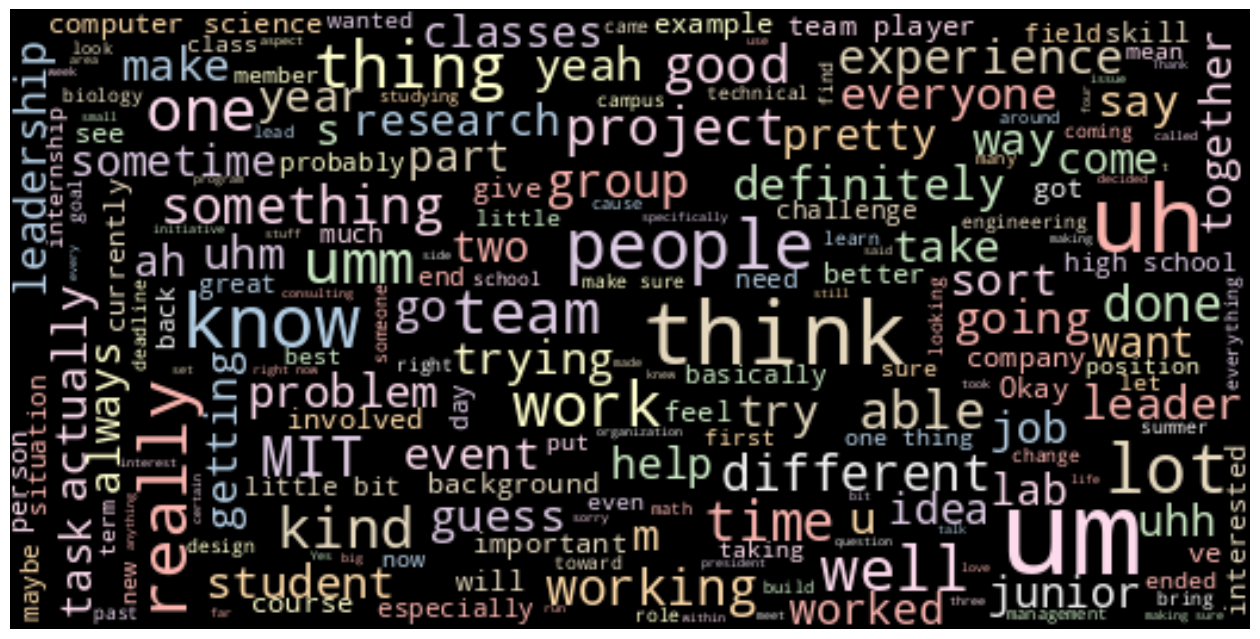

In [459]:
structured_true = " ".join(msg for msg in df[df['StructuredAnswers'] == True].Transcript)
structured_true_cloud = WordCloud(width =520, height =260, stopwords = STOPWORDS, max_font_size = 50, background_color = "black", colormap = 'Pastel1').generate(structured_true)
plt.figure(figsize=(16,10))
plt.imshow(structured_true_cloud, interpolation = 'bilinear')
plt.axis('off') # turn off axis
plt.show()

### Structured = False

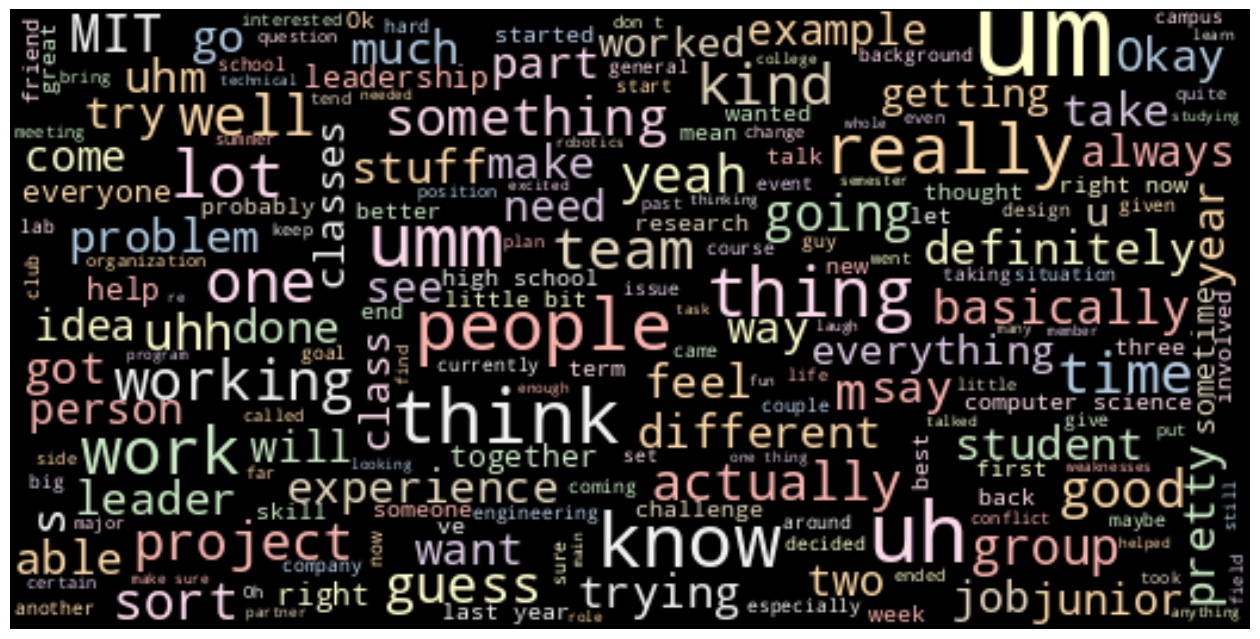

In [460]:
structured_false = " ".join(msg for msg in df[df['StructuredAnswers'] == False].Transcript)
structured_false_cloud = WordCloud(width =520, height =260, stopwords = STOPWORDS, max_font_size = 50, background_color = "black", colormap = 'Pastel1').generate(structured_false)
plt.figure(figsize=(16,10))
plt.imshow(structured_false_cloud, interpolation = 'bilinear')
plt.axis('off') # turn off axis
plt.show()

In [461]:
df['text_length'] = df['Transcript'].apply(len)
df.head()

,InterviewID,Transcript,Overall,RecommendHiring,Colleague,Engaged,Excited,EyeContact,Smiled,SpeakingRate,...,Paused,EngagingTone,StructuredAnswers,Calm,NotStressed,Focused,Authentic,NotAwkward,Total,text_length
0,P1,Im pretty good. ok uhm so have you looked at...,True,True,True,True,True,True,False,True,...,True,True,True,False,False,True,False,True,False,2762
1,P10,Great how about you? I'm a little [???] by th...,False,False,False,False,False,False,False,True,...,True,False,False,False,False,False,False,False,False,5305
2,P11,Uhh I’m a junior at MIT uhh I’m double major...,False,False,False,False,False,False,False,True,...,True,False,True,False,False,True,False,False,False,3639
3,P12,I'm good how are you? Ok so I'm a Junior at...,True,True,True,True,True,False,True,True,...,False,True,False,True,True,False,True,False,True,2977
4,P13,Good. Ok umm I'm currently a junior at M.I.T...,False,False,False,False,False,False,False,False,...,True,False,True,True,False,True,False,False,False,3111


In [462]:
X_train, X_test, y_train, y_test = train_test_split(df['Transcript'], df['StructuredAnswers'], test_size=0.2, random_state=42)

In [485]:
# Defining pre-processing parameters
max_len = 50
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 500

In [486]:
tokenizer = Tokenizer(num_words = vocab_size,
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(X_train)

In [487]:
# Get the word_index
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

4737

In [488]:
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)


In [489]:
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

In [490]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (110, 50)
Shape of testing tensor:  (28, 50)


### Dense Model

In [515]:
# Define parameter
embedding_dim = 16
drop_value = 0.2
n_dense = 24
# Define Dense Model Architecture
model = Sequential()
model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length = max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [516]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [517]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(training_padded,
                    y_train,
                    epochs=num_epochs,
                    validation_data=(testing_padded, y_test),
                    callbacks =[early_stop],
                    verbose=2)

Epoch 1/30
4/4 - 1s - loss: 0.6932 - accuracy: 0.4909 - val_loss: 0.6938 - val_accuracy: 0.3929 - 666ms/epoch - 166ms/step
Epoch 2/30
4/4 - 0s - loss: 0.6923 - accuracy: 0.5273 - val_loss: 0.6942 - val_accuracy: 0.3929 - 33ms/epoch - 8ms/step
Epoch 3/30
4/4 - 0s - loss: 0.6914 - accuracy: 0.5364 - val_loss: 0.6949 - val_accuracy: 0.3571 - 28ms/epoch - 7ms/step
Epoch 4/30
4/4 - 0s - loss: 0.6905 - accuracy: 0.5364 - val_loss: 0.6962 - val_accuracy: 0.3571 - 32ms/epoch - 8ms/step
Epoch 5/30
4/4 - 0s - loss: 0.6887 - accuracy: 0.5364 - val_loss: 0.6971 - val_accuracy: 0.3571 - 31ms/epoch - 8ms/step
Epoch 6/30
4/4 - 0s - loss: 0.6875 - accuracy: 0.5364 - val_loss: 0.6985 - val_accuracy: 0.3571 - 30ms/epoch - 8ms/step
Epoch 7/30
4/4 - 0s - loss: 0.6860 - accuracy: 0.5364 - val_loss: 0.6996 - val_accuracy: 0.3571 - 32ms/epoch - 8ms/step
Epoch 8/30
4/4 - 0s - loss: 0.6851 - accuracy: 0.5364 - val_loss: 0.7001 - val_accuracy: 0.3571 - 29ms/epoch - 7ms/step
Epoch 9/30
4/4 - 0s - loss: 0.6826 - 

In [518]:
loss, accuracy = model.evaluate(testing_padded, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

1/1 [==============================] - 0s 20ms/step - loss: 0.7015 - accuracy: 0.3929
Test Loss: 0.7014837861061096, Test Accuracy: 0.3928571343421936


### LSTM

In [519]:
# Define parameter
n_lstm = 256
drop_lstm = 0.2
# Define LSTM Model
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model1.add(SpatialDropout1D(drop_lstm))
model1.add(LSTM(n_lstm, return_sequences=False))
model1.add(Dropout(drop_lstm))
model1.add(Dense(1, activation='sigmoid'))

In [520]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [521]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=10)
history = model1.fit(training_padded,
                    y_train,
                    epochs=num_epochs,
                    validation_data=(testing_padded, y_test),
                    callbacks =[early_stop],
                    verbose=2)

Epoch 1/30
4/4 - 2s - loss: 0.6948 - accuracy: 0.4818 - val_loss: 0.7006 - val_accuracy: 0.3571 - 2s/epoch - 614ms/step
Epoch 2/30
4/4 - 0s - loss: 0.6912 - accuracy: 0.5364 - val_loss: 0.6991 - val_accuracy: 0.3571 - 456ms/epoch - 114ms/step
Epoch 3/30
4/4 - 1s - loss: 0.6885 - accuracy: 0.5455 - val_loss: 0.7037 - val_accuracy: 0.3571 - 517ms/epoch - 129ms/step
Epoch 4/30
4/4 - 1s - loss: 0.6829 - accuracy: 0.5364 - val_loss: 0.7176 - val_accuracy: 0.3571 - 645ms/epoch - 161ms/step
Epoch 5/30
4/4 - 1s - loss: 0.6641 - accuracy: 0.5364 - val_loss: 1.3629 - val_accuracy: 0.3571 - 675ms/epoch - 169ms/step
Epoch 6/30
4/4 - 0s - loss: 0.7568 - accuracy: 0.5818 - val_loss: 0.7025 - val_accuracy: 0.3571 - 449ms/epoch - 112ms/step
Epoch 7/30
4/4 - 0s - loss: 0.6628 - accuracy: 0.8545 - val_loss: 0.6931 - val_accuracy: 0.5714 - 461ms/epoch - 115ms/step
Epoch 8/30
4/4 - 0s - loss: 0.6671 - accuracy: 0.7909 - val_loss: 0.6914 - val_accuracy: 0.5714 - 452ms/epoch - 113ms/step
Epoch 9/30
4/4 - 0s

In [522]:
loss, accuracy = model1.evaluate(testing_padded, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

1/1 [==============================] - 0s 41ms/step - loss: 0.9163 - accuracy: 0.5714
Test Loss: 0.9163273572921753, Test Accuracy: 0.5714285969734192


### Bi-LSTM

In [499]:
model2 = Sequential()
model2.add(Embedding(vocab_size,
                     embedding_dim,
                     input_length = max_len))
model2.add(Bidirectional(LSTM(n_lstm,
                              return_sequences = False)))
model2.add(Dropout(drop_lstm))
model2.add(Dense(1, activation='sigmoid'))

In [500]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [501]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=10)
history = model2.fit(training_padded,
                    y_train,
                    epochs=num_epochs,
                    validation_data=(testing_padded, y_test),
                    callbacks =[early_stop],
                    verbose=2)

Epoch 1/30
4/4 - 4s - loss: 0.6946 - accuracy: 0.4273 - val_loss: 0.6944 - val_accuracy: 0.3571 - 4s/epoch - 1s/step
Epoch 2/30
4/4 - 1s - loss: 0.6902 - accuracy: 0.5455 - val_loss: 0.7041 - val_accuracy: 0.3571 - 797ms/epoch - 199ms/step
Epoch 3/30
4/4 - 1s - loss: 0.6879 - accuracy: 0.5364 - val_loss: 0.7258 - val_accuracy: 0.3571 - 800ms/epoch - 200ms/step
Epoch 4/30
4/4 - 1s - loss: 0.6840 - accuracy: 0.5364 - val_loss: 0.7244 - val_accuracy: 0.3571 - 787ms/epoch - 197ms/step
Epoch 5/30
4/4 - 1s - loss: 0.6725 - accuracy: 0.5364 - val_loss: 0.7101 - val_accuracy: 0.3571 - 807ms/epoch - 202ms/step
Epoch 6/30
4/4 - 1s - loss: 0.6573 - accuracy: 0.6455 - val_loss: 0.6822 - val_accuracy: 0.5714 - 797ms/epoch - 199ms/step
Epoch 7/30
4/4 - 1s - loss: 0.9074 - accuracy: 0.7091 - val_loss: 0.6586 - val_accuracy: 0.6071 - 954ms/epoch - 238ms/step
Epoch 8/30
4/4 - 1s - loss: 0.5944 - accuracy: 0.6818 - val_loss: 0.6998 - val_accuracy: 0.5000 - 1s/epoch - 296ms/step
Epoch 9/30
4/4 - 1s - los

In [502]:
loss, accuracy = model2.evaluate(testing_padded, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

1/1 [==============================] - 0s 51ms/step - loss: 0.7066 - accuracy: 0.5357
Test Loss: 0.7065603137016296, Test Accuracy: 0.5357142686843872


### GRU

In [503]:
model3 = Sequential()
model3.add(Embedding(vocab_size,
                     embedding_dim,
                     input_length = max_len))
model3.add(SpatialDropout1D(0.2))
model3.add(GRU(128, return_sequences = False))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation = 'sigmoid'))

In [504]:
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [505]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=10)
history = model3.fit(training_padded,
                    y_train,
                    epochs=num_epochs,
                    validation_data=(testing_padded, y_test),
                    callbacks =[early_stop],
                    verbose=2)

Epoch 1/30
4/4 - 3s - loss: 0.6935 - accuracy: 0.4818 - val_loss: 0.6966 - val_accuracy: 0.3571 - 3s/epoch - 764ms/step
Epoch 2/30
4/4 - 0s - loss: 0.6912 - accuracy: 0.5455 - val_loss: 0.7029 - val_accuracy: 0.3571 - 146ms/epoch - 36ms/step
Epoch 3/30
4/4 - 0s - loss: 0.6889 - accuracy: 0.5364 - val_loss: 0.7053 - val_accuracy: 0.3571 - 141ms/epoch - 35ms/step
Epoch 4/30
4/4 - 0s - loss: 0.6870 - accuracy: 0.5364 - val_loss: 0.7076 - val_accuracy: 0.3571 - 132ms/epoch - 33ms/step
Epoch 5/30
4/4 - 0s - loss: 0.6841 - accuracy: 0.5364 - val_loss: 0.7114 - val_accuracy: 0.3571 - 134ms/epoch - 33ms/step
Epoch 6/30
4/4 - 0s - loss: 0.6817 - accuracy: 0.5364 - val_loss: 0.7173 - val_accuracy: 0.3571 - 140ms/epoch - 35ms/step
Epoch 7/30
4/4 - 0s - loss: 0.6781 - accuracy: 0.5364 - val_loss: 0.7288 - val_accuracy: 0.3571 - 145ms/epoch - 36ms/step
Epoch 8/30
4/4 - 0s - loss: 0.6667 - accuracy: 0.5364 - val_loss: 0.7284 - val_accuracy: 0.3571 - 151ms/epoch - 38ms/step
Epoch 9/30
4/4 - 0s - loss

In [506]:
loss, accuracy = model3.evaluate(testing_padded, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

1/1 [==============================] - 0s 31ms/step - loss: 0.8095 - accuracy: 0.3571
Test Loss: 0.8094901442527771, Test Accuracy: 0.3571428656578064
